In [4]:
import math
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler



In [3]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [5]:
# Load dataset
dataset = pd.read_csv('technical_indicators/BHP/Trend/BHPTrend.csv', header=0, index_col=0)

values = dataset.values
values = values.astype('float32')
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Frame as supervised learning
reframed = series_to_supervised(scaled, 7, 2)
print(reframed.head())


    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7    0.473464   0.399862   0.572502   0.505595   0.000000   0.270387   
8    0.480391   0.473464   0.399862   0.572502   0.136755   0.319360   
9    0.495793   0.480391   0.473464   0.399862   0.231230   0.370372   
10   0.591920   0.495793   0.480391   0.473464   0.112204   0.480676   
11   0.504141   0.591920   0.495793   0.480391   0.091429   0.333697   

    var7(t-7)  var8(t-7)  var9(t-7)  var10(t-7)  ...  var20(t+1)  var21(t+1)  \
7    0.251201   0.260576   0.349954    0.000000  ...    0.030320    0.292107   
8    0.301592   0.224096   0.307113    0.000000  ...    0.029384    0.336335   
9    0.339905   0.276756   0.277163    0.136755  ...    0.029384    0.353590   
10   0.429497   0.365488   0.375592    0.231230  ...    0.028448    0.261199   
11   0.430604   0.380006   0.392274    0.112204  ...    0.025753    0.287804   

    var22(t+1)  var23(t+1)  var24(t+1)  var25(t+1)  var26(t+1)  var27(t+1)  \
7     0.

In [19]:
# Split into train and test sets
values = reframed.values
train = values[:4199, :]
test = values[4200:, :]
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].


(4199, 1, 260) (4199,) (1047, 1, 260) (1047,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM Model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, output_dim=1, dropout=0.3):
        super(LSTMModel, self).__init__()
        
        # LSTM Layers
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)

        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)

        self.lstm3 = nn.LSTM(hidden_dim2, hidden_dim2, batch_first=True)
        self.dropout3 = nn.Dropout(dropout)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim2, output_dim)
        self.activation = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout3(x)
        
        x = self.fc(x[:, -1, :])  # Get last time-step output
        x = self.activation(x)
        
        return x

# Define Model Hyperparameters
input_dim = train_X.shape[2]  # Number of features per time step
hidden_dim1 = 64
hidden_dim2 = 32
output_dim = 1  # Binary classification output
dropout = 0.3

# Initialize model
model = LSTMModel(input_dim, hidden_dim1, hidden_dim2, output_dim, dropout)

# Define Loss Function & Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Epoch [10/50], Loss: 0.6942
Epoch [20/50], Loss: 0.6920
Epoch [30/50], Loss: 0.6909
Epoch [40/50], Loss: 0.6839
Epoch [50/50], Loss: 0.6654


Epoch [50/500], Train Loss: 0.3626, Val Loss: 0.3415
Epoch [100/500], Train Loss: 0.2237, Val Loss: 0.2170
Epoch [150/500], Train Loss: 0.1745, Val Loss: 0.1458
Epoch [200/500], Train Loss: 0.1442, Val Loss: 0.1309
Epoch [250/500], Train Loss: 0.1331, Val Loss: 0.1455
Epoch [300/500], Train Loss: 0.1412, Val Loss: 0.1151
Epoch [350/500], Train Loss: 0.1208, Val Loss: 0.1373
Epoch [400/500], Train Loss: 0.1154, Val Loss: 0.1334
Epoch [450/500], Train Loss: 0.1059, Val Loss: 0.1063
Epoch [500/500], Train Loss: 0.0975, Val Loss: 0.1111


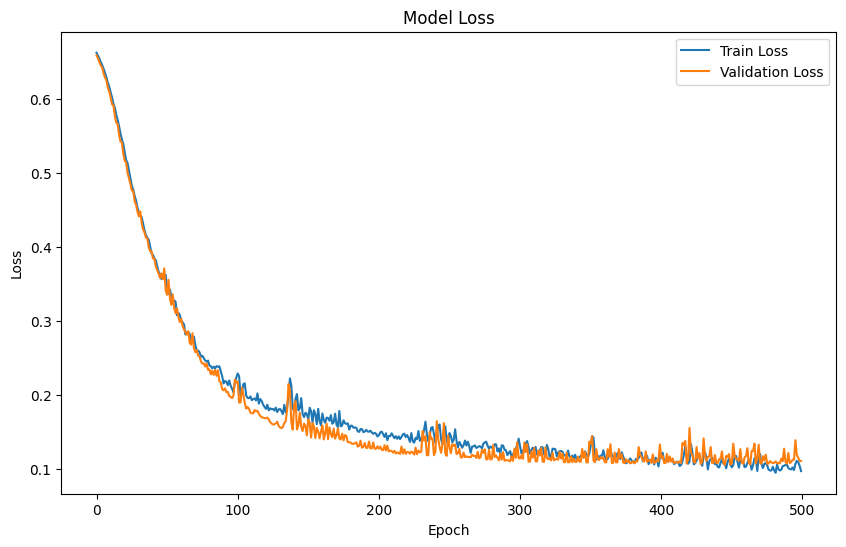

In [14]:
train_X_tensor = torch.tensor(train_X, dtype=torch.float32).to(device)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32).unsqueeze(1).to(device)  # Ensure shape is (batch_size, 1)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).unsqueeze(1).to(device)

# Training parameters
epochs = 500
batch_size = 80
train_losses = []
val_losses = []

# Training Loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_X_tensor)
    loss = criterion(outputs, train_y_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_X_tensor)
        val_loss = criterion(val_outputs, test_y_tensor)

    # Store loss values
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()


In [15]:
model.eval()

# Convert test data to PyTorch tensor and move to device
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)

# Generate Predictions
with torch.no_grad():
    yhat_probs = model(test_X_tensor)  # Probability predictions

# Convert probabilities to NumPy
yhat_probs = yhat_probs.cpu().numpy()

# Convert probabilities to class labels (0 or 1)
yhat_classes = (yhat_probs > 0.5).astype(int)

# Print predictions
print("Predicted Probabilities:\n", yhat_probs[:10])  # Show first 10 predictions
print("Predicted Classes:\n", yhat_classes[:10])  # Show first 10 class labels



Predicted Probabilities:
 [[0.011897  ]
 [0.00259186]
 [0.9516218 ]
 [0.002788  ]
 [0.9988582 ]
 [0.9978829 ]
 [0.997617  ]
 [0.9525337 ]
 [0.00257439]
 [0.9633812 ]]
Predicted Classes:
 [[0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]]


In [ ]:
# Evaluate the model
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y, yhat_classes)
print('Accuracy: %f' % accuracy)
# Precision tp / (tp + fp)
precision = precision_score(test_y, yhat_classes)
print('Precision: %f' % precision)
# Recall: tp / (tp + fn)
recall = recall_score(test_y, yhat_classes)
print('Recall: %f' % recall)
# F1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, yhat_classes)
print('F1 score: %f' % f1)
# Kappa
kappa = cohen_kappa_score(test_y, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(test_y, yhat_probs)
print('ROC AUC: %f' % auc)
# Confusion matrix
matrix = confusion_matrix(test_y, yhat_classes)
print(matrix)


Accuracy: 0.953200
Precision: 0.977358
Recall: 0.933333
F1 score: 0.954839
Cohens kappa: 0.906329
ROC AUC: 0.993071
[[480  12]
 [ 37 518]]


In [21]:
# Generate future predictions
n_future = 20
a = values[-n_future:,:-1]
a = a.reshape(a.shape[0], 1, -1)
print(a.shape)
a_tensor = torch.tensor(a, dtype=torch.float32).to(device)

with torch.no_grad():
    forecast = model(a_tensor)

forecast = forecast.cpu().numpy()
forecast = np.asarray(forecast)

forecast_classes = (forecast > 0.5).astype(int)
a = a.reshape((a.shape[0], a.shape[2]))
inv_forecast = np.concatenate((forecast, a[:, -28:]), axis=1)  # Adjust based on your feature count
inv_forecast = scaler.inverse_transform(inv_forecast)
inv_forecast = inv_forecast[:, 0]
print(inv_forecast)


(20, 1, 260)
[ 0.1676598   0.16726722  0.16640277  0.16705403 -0.17999017  0.1594612
 -0.11345205  0.16715115 -0.07303254 -0.18675698  0.16724117  0.10739543
  0.16481945 -0.18412994 -0.13234456 -0.18701662  0.16713841 -0.18574476
  0.1286877   0.16549698]


In [25]:
print(test_y)

[0. 0. 1. ... 0. 1. 1.]
